In [35]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#Import module from folder in another directory
import importlib.util
spec = importlib.util.spec_from_file_location("outliers", "data_preprocessing/outliers.py")
outliers = importlib.util.module_from_spec(spec)
spec.loader.exec_module(outliers)

import sys
sys.path.append('data_preprocessing')
import data_preprocessing.summary as summary
import data_preprocessing.normalize as normalize

import warnings
warnings.filterwarnings("ignore")

from sklearn.cross_validation import train_test_split
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
import xgboost as xgb

%matplotlib inline

rng = np.random.RandomState(31337)

In [36]:
train_data = pd.read_csv('../data/input/ames_train.csv')
test_data = pd.read_csv('../data/input/ames_test.csv')

geo_train_data = pd.read_csv('../data/input/ames_geodemo_train.csv')
geo_test_data = pd.read_csv('../data/input/ames_geodemo_train.csv')

# Modelling without geo/census data

In [38]:
train_data = normalize.fill_in_missing_values(train_data)
train_data = outliers.remove_outliers(train_data)
#train_data = normalize.normalize(train_data)

test_data = normalize.fill_in_missing_values(test_data)
test_data = outliers.remove_outliers(test_data)
#test_data = normalize.normalize(test_data)

In [39]:
train_data = train_data.select_dtypes(include=[np.number])
test_data = test_data.select_dtypes(include=[np.number])

X_train, X_test, y_train, y_test = train_test_split(train_data.loc[:, train_data.columns != 'SalePrice'], 
                                                  train_data['SalePrice'],
                                                  test_size=0.2, random_state=42)

X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

## Random Forest

In [63]:
clf = RandomForestRegressor(n_estimators=500)

clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

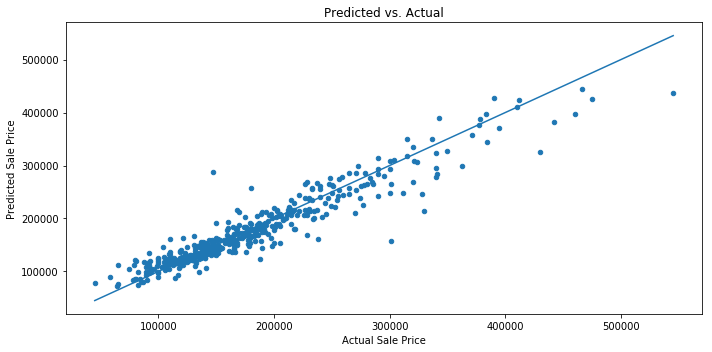

In [64]:
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, s=20)
plt.title('Predicted vs. Actual')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)])
plt.tight_layout()

In [65]:
r2_score(y_test,y_pred)

0.89725767079842

## XGBoost with 5 folds

In [66]:
kf = KFold(n_splits=5,shuffle=True,random_state=rng)
for train_index,test_index in kf.split(X_train):
    clf = xgb.XGBRegressor().fit(X_train[train_index],y_train[train_index])
    y_pred = clf.predict(X_train[test_index])
    actual = y_train[test_index]
    print(r2_score(actual, y_pred))

0.886039948673
0.928187094447
0.920687466041
0.910162627564
0.905506376333


## Simple XGBoost

In [44]:
clf = xgb.XGBRegressor()
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

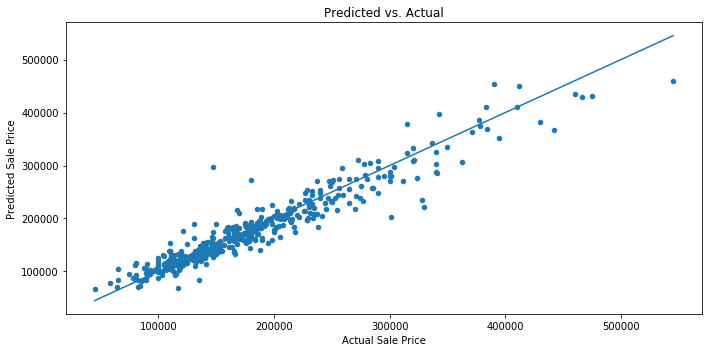

In [45]:
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, s=20)
plt.title('Predicted vs. Actual')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)])
plt.tight_layout()

In [46]:
r2_score(y_test,y_pred)

0.91139722687174318

## GridSearchCV With xgboost parameter optimisation

In [47]:
xgb_clf = xgb.XGBRegressor()
gridSearchClf = GridSearchCV(xgb_clf, {'max_depth': [2,4,6],
                    'n_estimators': [50,100,200]}, verbose=1)
gridSearchClf.fit(X_train,y_train)
y_pred = gridSearchClf.predict(X_test)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    7.3s finished


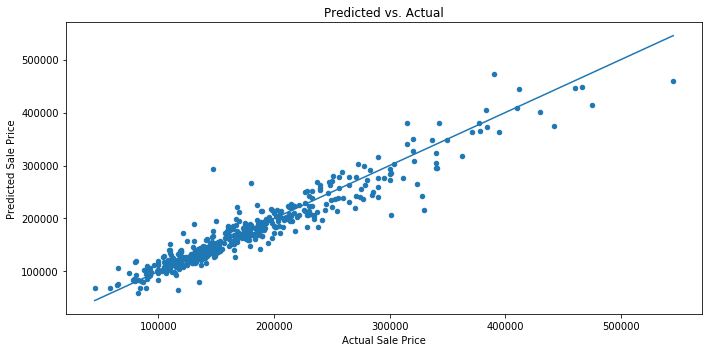

In [48]:
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, s=20)
plt.title('Predicted vs. Actual')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)])
plt.tight_layout()

In [49]:
r2_score(y_test,y_pred)

0.91175023679570377

## Decision Tree Regression and Adaboosting Regression

In [68]:
regr_1 = DecisionTreeRegressor(max_depth=4)

regr_2 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),
                          n_estimators=300, random_state=rng)

In [69]:
regr_1.fit(X_train,y_train)
y_pred = regr_1.predict(X_test)

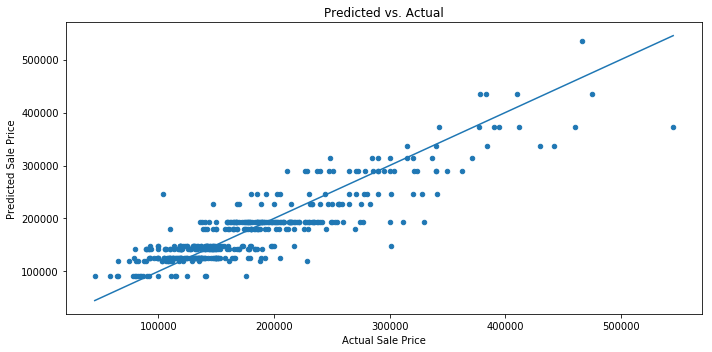

In [70]:
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, s=20)
plt.title('Predicted vs. Actual')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)])
plt.tight_layout()

In [71]:
r2_score(y_test,y_pred)

0.77502047670426699

In [72]:
regr_2.fit(X_train,y_train)
y_pred = regr_2.predict(X_test)

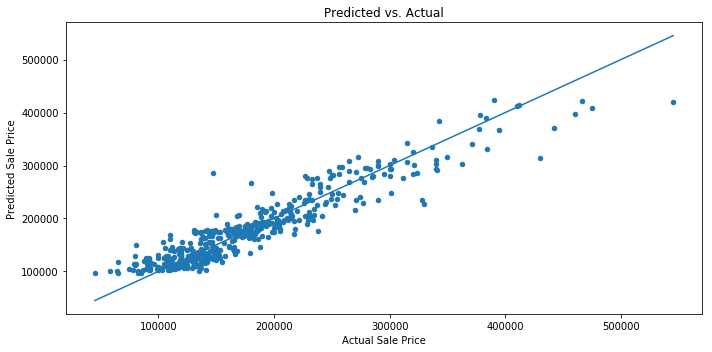

In [73]:
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, s=20)
plt.title('Predicted vs. Actual')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)])
plt.tight_layout()

In [74]:
r2_score(y_test,y_pred)

0.87958268123002181

# Modelling with geo/census data 

In [75]:
geo_train_data = normalize.fill_in_missing_values(geo_train_data)
geo_train_data = outliers.remove_outliers(train_data)
#train_data = normalize.normalize(train_data)

geo_test_data = normalize.fill_in_missing_values(test_data)
geo_test_data = outliers.remove_outliers(test_data)
#test_data = normalize.normalize(test_data)

In [76]:
geo_train_data = geo_train_data.select_dtypes(include=[np.number])
geo_test_data = geo_test_data.select_dtypes(include=[np.number])

X_train, X_test, y_train, y_test = train_test_split(geo_train_data.loc[:, geo_train_data.columns != 'SalePrice'], 
                                                  geo_train_data['SalePrice'],
                                                  test_size=0.2, random_state=42)

X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [77]:
clf = RandomForestRegressor(n_estimators=500)

clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

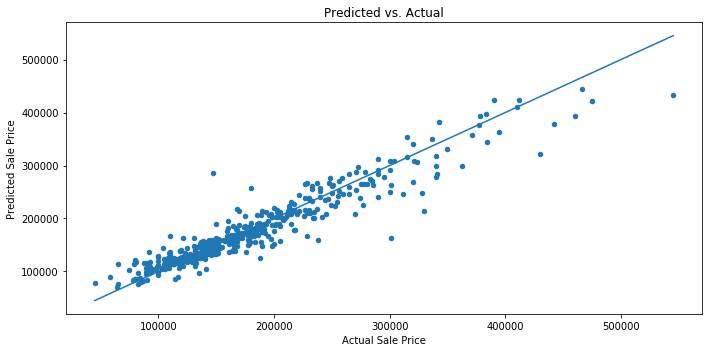

In [78]:
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, s=20)
plt.title('Predicted vs. Actual')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)])
plt.tight_layout()

In [79]:
r2_score(y_test,y_pred)

0.89708063365999202

In [80]:
kf = KFold(n_splits=5,shuffle=True,random_state=rng)
for train_index,test_index in kf.split(X_train):
    clf = xgb.XGBRegressor().fit(X_train[train_index],y_train[train_index])
    y_pred = clf.predict(X_train[test_index])
    actual = y_train[test_index]
    print(r2_score(actual, y_pred))

0.928113019887
0.909021381077
0.886721668125
0.901489367371
0.928813729892


In [81]:
clf = xgb.XGBRegressor()
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

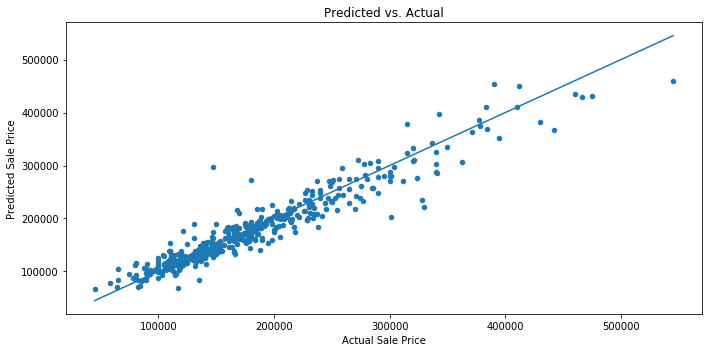

In [82]:
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, s=20)
plt.title('Predicted vs. Actual')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)])
plt.tight_layout()

In [83]:
r2_score(y_test,y_pred)

0.91139722687174318